In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../../'); from config import *
configure_pylab()

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Desktop/lgcpspatial/python/notebooks/hyperparameter_fits/


r2288_180515b_tet2_cell2_GC.mat


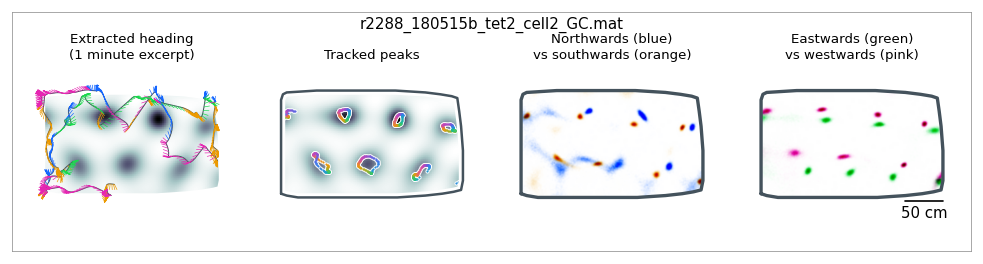

In [2]:
L  = 128
fn = datafiles[6] #3
fn = 'r2405_051216b_cell1816.mat'
fn = 'r2288_180515b_tet2_cell2_GC.mat' # Best

nsamples = 4000
upsample = 2
Nh       = 90
hh       = linspace(0,2*pi,Nh+1)[:-1]
    
print(fn)
data   = Dataset.from_file(datadir+fn).prepare(L)
arena  = data.arena
saveto = fn[:-4]+'.hyperparameters.p'
P,V,θ  = pickle.load(open(fitdir+saveto,'rb'))
kernel = kernelft(data.shape,P,V,style='grid',angle=θ)
result = lgcp2d(kernel,data.N,data.Y,data.prior_mean)[0]
sx,sy  = data.smoothed_position(Fl=2.0)
hg = data.smoothed_heading_angle(Fl=2.0)
hd = data.smoothed_head_direction(Fl=2.0)
h  = hd # Use head direction

# Get heading weights
def heading_helper(hi):
    w   = maximum(0,cos(h-hi))**2
    N,K = arena.binto(data.xy,spikes=data.spikes,weights=w)
    result,model = lgcp2d(kernel,N,K,data.prior_mean)
    hxy = interpolate_peaks(result.info.r,P/2.5)[::-1]
    hxy = hxy[:,arena.contains(hxy,unit='unit')]
    return hxy
peaks = parmap(heading_helper,hh)

# Get heading weights
def heading_helper_samples(hi):
    w   = maximum(0,cos(h-hi))**2
    N,K = arena.binto(data.xy,spikes=data.spikes,weights=w)
    result,model = lgcp2d(kernel,N,K,data.prior_mean)
    return model.sample(nsamples)
samples = parmap(heading_helper_samples,NSEW)

cardinal = float32([peak_density(s,upsample) for s in samples])
mask2    = arena.make_mask(*(arena.shape*upsample))
scaled   = [c/nanpercentile(c[mask2],99.2) for c in cardinal]

figure(0,(8,2),120,facecolor='w')
subplots_adjust(0,0,1,.9,0,0)

subplot(141) # PLOT EXTRACTED HEADING
a,b,skip = 1500, 4500, 4
vz = exp(1j*h[a:b:skip])*.05
sz = p2c([sx,sy])[a:b:skip]
z  = array([sz,sz+vz,sz*NaN]).T.ravel()
arena.imshow(result.info.r,cmap='bone_r',zorder=-100)
x0 = mean(xlim())
y0 = mean(ylim())
z0 = x0+1j*y0
vz = exp(1j*h[a:b:skip])*.075
sz = p2c([sx,sy])[a:b:skip]
z  = array([sz,sz+vz,sz*NaN]).T
plot(sx[a:b],sy[a:b],lw=.6,color=BLACK,zorder=2)
plot(*c2p(z[cos(h[a:b:skip]-hN)>cos(pi/4)].ravel()),color=cN,lw=.4)
plot(*c2p(z[cos(h[a:b:skip]-hS)>cos(pi/4)].ravel()),color=cS,lw=.4)
plot(*c2p(z[cos(h[a:b:skip]-hE)>cos(pi/4)].ravel()),color=cE,lw=.4)
plot(*c2p(z[cos(h[a:b:skip]-hW)>cos(pi/4)].ravel()),color=cW,lw=.4)
title('Extracted heading\n(1 minute excerpt)',pad=0)
subplot(142) # PLOT TRACKED PEAKS
arena.imshow(result.info.r,cmap='bone_r')
for i,xy in enumerate(peaks):
    scatter(*arena.unit_to_meters(xy),color='w',marker='.',lw=0,s=24)
for i,xy in enumerate(peaks):
    color = ESWNmix(i/Nh)
    scatter(*arena.unit_to_meters(xy),color=color,marker='.',lw=0,s=7)
plot(*arena.perim_m.T)
title('Tracked peaks',pad=0)

subplot(143) # PLOT NS
rgb = 1-einsum('dc,dhw->hwc',1-colorNSEW[:2],scaled[:2])
arena.imshow(clip(rgb,0,1),color=BLACK,lw=2,interpolation='bicubic')
title('Northwards (blue)\nvs southwards (orange)',pad=0)

subplot(144) # PLOT EW
rgb = 1-einsum('dc,dhw->hwc',1-colorNSEW[2:],scaled[2:])
arena.imshow(clip(rgb,0,1),color=BLACK,lw=2,interpolation='bicubic')
title('Eastwards (green)\nvs westwards (pink)',pad=0)
xscalebar(np.max(arena.perim_m.T[0])-.25,.50,'50 cm',np.max(arena.perim_m.T[1])-px2y(5))

figurebox()
suptitle(fn)
savefig('fig5v6_part_partition_%s.pdf'%fn)
savefig('fig5v6_part_partition_%s.svg'%fn)
show()